In [37]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
data = data[['Open', 'High', 'Low', 'Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

obs = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close'])
act = obs['Close'].shift(-1)
spac = np.arange(10000)
spac = spac/10000
spac.shape[-1]

obs = obs.iloc[:-1].reset_index(drop=True)
act = act.dropna()

print(obs.head())
print(act.head())


[*********************100%%**********************]  1 of 1 completed

       Open      High       Low     Close
0  0.135658  0.143266  0.163891  0.150853
1  0.137469  0.143226  0.166491  0.145055
2  0.130782  0.141994  0.159049  0.149761
3  0.142823  0.143862  0.168436  0.146961
4  0.137489  0.150896  0.167801  0.156491
0    0.145055
1    0.149761
2    0.146961
3    0.156491
4    0.169278
Name: Close, dtype: float64


In [86]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.c1 = nn.Linear(state_size, 100)
        self.c2 = nn.Linear(100, 100)
        self.c3 = nn.Linear(100, action_size)
    def forward(self, x):
        x = torch.relu(self.c1(x))
        x = torch.relu(self.c2(x))
        return self.c3(x)

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=1, gamma=0.99, epsilon=1, epsilon_decay=0.9, epsilon_min=0.01, memory_size=100, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        if len(self.memory) > self.memory_size:
            del self.memory[0]

    def act(self, state, prev, target):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(spac)
        else:
            q_values = self.model(torch.FloatTensor(state)).detach().numpy()
            curr = np.argmax(q_values)/10000  # Choose the action with the highest Q-value
            return target + (curr - prev)/500
            # if abs(curr - prev) >= 0.3:
            #     return prev + 0.4*(curr - prev)    
            # else:
            #     return curr 

    def replay(self):
        if len(self.memory) < 64:
            return

            
        indices = random.sample(range(len(self.memory)), 64)
        array = range(len(self.memory))
        minibatch = [self.memory[idx] for idx in indices]
        states = np.array([item[0] for item in minibatch])
        actions = np.array([item[1] for item in minibatch])
        rewards = np.array([item[2] for item in minibatch])
        next_states = np.array([item[3] for item in minibatch])
        q_values_next = self.target_model(torch.FloatTensor(next_states)).detach().numpy()
        targets = rewards +  self.gamma * np.max(q_values_next, axis=1)
        q_values = self.model(torch.FloatTensor(states)).detach().numpy()
        q_values[np.arange(len(q_values)), (actions*10000).astype(int)] = targets
        self.optimizer.zero_grad()
        loss = self.loss_function(self.model(torch.FloatTensor(states)), torch.FloatTensor(q_values))
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

obs_np = obs.to_numpy()
act_np = act.to_numpy()


state_size = obs_np.shape[1]
action_size = 10000  

agent = DQNAgent(state_size, action_size)


In [87]:
print("2")
predicted = np.array([])
prev = 0
for episode in range(len(obs_np)):
    state = obs_np[episode]  
    done = False
    total_reward = 0
    
    while not done:
        target = state[3]
        action = agent.act(state, prev,target)
        print(action)
        next_state = obs_np[episode + 1] if episode < len(obs_np) - 1 else obs_np[-1]
        reward = 1/abs((next_state[3]-action))
        predicted = np.append(predicted, action)
        prev = action
        
        if len(agent.memory) >= agent.batch_size:
            done = True

        agent.remember(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    agent.replay()
    agent.update_target_model()
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
predicted

2
0.2741
0.6959
0.3583
0.4237
0.4821
0.9695
0.2136
0.5625
0.6755
0.6352
0.579
0.5676
0.9206
0.5094
0.4987
0.6115
0.0277
0.9892
0.458
0.4094
0.1399
0.3494
0.3763
0.4503
0.1726
0.9719
0.4315
0.1505
0.281
0.1994
0.3036
0.1184
0.9138
0.981
0.7253
0.2897
0.6824
0.3174
0.6647
0.7752
0.5579
0.6597
0.2713
0.6932
0.8092
0.2076
0.5917
0.948
0.3831
0.1082
0.4991
0.0658
0.3871
0.9331
0.7454
0.5125
0.9088
0.0537
0.8808
0.987
0.9348
0.8308
0.3162
0.5951
0.0633
Episode: 1, Total Reward: 725.7985254839602
0.339
Episode: 2, Total Reward: 5.284315922740182
0.4358
Episode: 3, Total Reward: 3.462140514637989
0.7108
Episode: 4, Total Reward: 1.8040491377235826
0.4304
Episode: 5, Total Reward: 3.8296206118731306
0.16869652825967701
Episode: 6, Total Reward: 507.41779636660266
0.0334
Episode: 7, Total Reward: 6.64758005703134
0.18458268175497497
Episode: 8, Total Reward: 108.11248778018602
0.1759826911119765
Episode: 9, Total Reward: 302.1057139450363
0.1729986261393094
Episode: 10, Total Reward: 134.8232435

array([2.74100000e-01, 6.95900000e-01, 3.58300000e-01, 4.23700000e-01,
       4.82100000e-01, 9.69500000e-01, 2.13600000e-01, 5.62500000e-01,
       6.75500000e-01, 6.35200000e-01, 5.79000000e-01, 5.67600000e-01,
       9.20600000e-01, 5.09400000e-01, 4.98700000e-01, 6.11500000e-01,
       2.77000000e-02, 9.89200000e-01, 4.58000000e-01, 4.09400000e-01,
       1.39900000e-01, 3.49400000e-01, 3.76300000e-01, 4.50300000e-01,
       1.72600000e-01, 9.71900000e-01, 4.31500000e-01, 1.50500000e-01,
       2.81000000e-01, 1.99400000e-01, 3.03600000e-01, 1.18400000e-01,
       9.13800000e-01, 9.81000000e-01, 7.25300000e-01, 2.89700000e-01,
       6.82400000e-01, 3.17400000e-01, 6.64700000e-01, 7.75200000e-01,
       5.57900000e-01, 6.59700000e-01, 2.71300000e-01, 6.93200000e-01,
       8.09200000e-01, 2.07600000e-01, 5.91700000e-01, 9.48000000e-01,
       3.83100000e-01, 1.08200000e-01, 4.99100000e-01, 6.58000000e-02,
       3.87100000e-01, 9.33100000e-01, 7.45400000e-01, 5.12500000e-01,
      

## import matplotlib.pyplot as plt
plt.plot(np.arange(len(predicted)), predicted, label='Predicted Actions')
plt.plot(np.arange(len(act_np)), act_np, label='Actual Actions')
plt.xlabel('Time Step')
plt.ylabel('Actions')
plt.title('Predicted vs Actual Actions')
plt.legend()
plt.show()

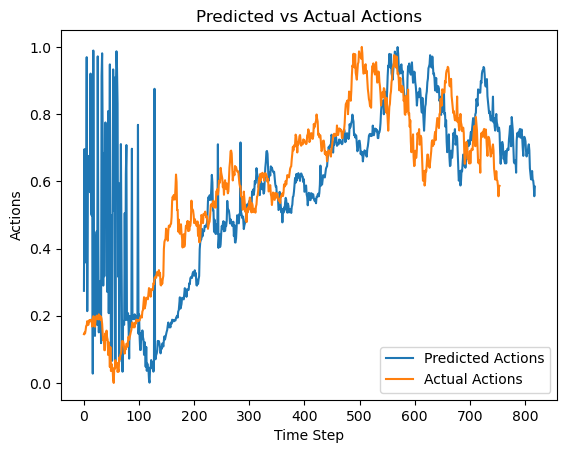

In [88]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(predicted)), predicted, label='Predicted Actions')
plt.plot(np.arange(len(act_np)), act_np, label='Actual Actions')
plt.xlabel('Time Step')
plt.ylabel('Actions')
plt.title('Predicted vs Actual Actions')
plt.legend()
plt.show()